In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pprint import pprint
from keras.models import Model
from keras.layers import Embedding
from keras.optimizers import Adam

2024-11-22 22:23:26.860446: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [97]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

In [98]:
def train_test_split_user(ratings, test_size=0.2):
    train_list = []
    test_list = []

    # Get all unique users
    for user_id in ratings['userId'].unique():
        # Filter the dataset to include only rows corresponding to curr user
        user_data = ratings[ratings['userId'] == user_id]
        # Check if user has rated more than 5 movies to meaningfully split data into train and test
        # Ex. user with 10 ratings -> 8 train, 2 test, but user with 3 ratings -> 2 train, 1 test
            # In the latter case, we would not have enough data to train the model
        # If user has rated more than 5 movies, split the data into train and test
        # Else, include all data in train
        if len(user_data) >= 5:
            train_data, test_data = train_test_split(user_data, test_size=test_size, random_state=42)
            train_list.append(train_data)
            test_list.append(test_data)
        else:
            train_list.append(user_data)
    
    # Combine training and testing data for all users into train and test
    train = pd.concat(train_list)
    test = pd.concat(test_list)
    return train, test

train_data, test_data = train_test_split_user(ratings)
print(train_data.head())
# We don't need timestamp column
train_data = train_data.drop(columns=['timestamp'])
test_data = test_data.drop(columns=['timestamp'])

     userId  movieId  rating  timestamp
55        1     1031     5.0  964982653
230       1     4006     4.0  964982903
69        1     1197     5.0  964981872
168       1     2596     5.0  964981144
109       1     1777     4.0  964981230


In [99]:
all_user_ids = pd.concat([train_data['userId'], test_data['userId']]).unique()
all_movie_ids = pd.concat([train_data['movieId'], test_data['movieId']]).unique()

# Create mappings from IDs to indices
user_id_mapping = {id: idx for idx, id in enumerate(all_user_ids)}
movie_id_mapping = {id: idx for idx, id in enumerate(all_movie_ids)}

# Apply mappings to the datasets
train_data['user_index'] = train_data['userId'].map(user_id_mapping)
train_data['movie_index'] = train_data['movieId'].map(movie_id_mapping)
test_data['user_index'] = test_data['userId'].map(user_id_mapping)
test_data['movie_index'] = test_data['movieId'].map(movie_id_mapping)

# Encode the ratings as class indices
rating_values = sorted(train_data['rating'].unique())


X_train_array = [train_data['user_index'].values, train_data['movie_index'].values]
y_train = train_data['rating'].values
X_test_array = [test_data['user_index'].values, test_data['movie_index'].values]
y_test = test_data['rating'].values

label_encoder = LabelEncoder()
y_train_class = label_encoder.fit_transform(y_train)
y_test_class = label_encoder.transform(y_test)

# train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)
# val_data['user_index'] = val_data['userId'].map(user_id_mapping)
# val_data['movie_index'] = val_data['movieId'].map(movie_id_mapping)

# X_val_array = [val_data['user_index'].values, val_data['movie_index'].values]
# y_val = val_data['rating'].values

In [100]:
print(X_val_array)
print(y_val)

[array([566,  90, 273, ..., 413, 413, 579]), array([ 940, 2014, 1264, ..., 2866,  973,  195])]
[2.  3.5 3.5 ... 4.  4.  4.5]


In [101]:
K = 100
n_movies = len(set(train_data['movieId']))
n_users = len(set(train_data['userId']))
## Initializing a input layer for users
user = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of users
u = keras.layers.Embedding(n_users, K, embeddings_initializer = 'he_normal', embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((K,))(u)

## Initializing a input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of movies
m = keras.layers.Embedding(n_movies, K, embeddings_initializer = 'he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((K,))(m)

## stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

## Adding a Dense layer to the architecture
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding an Output layer with Sigmoid activation funtion which gives output between 0 and 1
x = tf.keras.layers.Dense(len(rating_values))(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

## Adding a Lambda layer to convert the output to rating by scaling it with the help of available rating information
# x = tf.keras.layers.Lambda(lambda x: x*(max_rating - min_rating) + min_rating)(x)

## Defining the model
model = tf.keras.models.Model(inputs=[user,movie], outputs=x)
# optimizer = tf.keras.optimizers.Adam(lr=0.001)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005,
    # rho=0.9, momentum=0.01, epsilon=1e-07)

## Compiling the model
# model.compile(loss='binary_crossentropy', optimizer = optimizer)
# model.compile(loss='mean_squared_error', optimizer = optimizer,metrics=['accuracy'])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [102]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = model.fit(x = X_train_array,y=y_train, batch_size=128, epochs=70, verbose=1,shuffle=True, validation_data=(X_val_array, y_val), callbacks=[reduce_lr])

# without mappings loss = 1.134 accuracy = 0.3664

Epoch 1/70
629/629 [==============================] - 11s 15ms/step - loss: 1.3919 - accuracy: 0.2989 - val_loss: 1.1739 - val_accuracy: 0.3520 - lr: 0.0010
Epoch 2/70
629/629 [==============================] - 8s 13ms/step - loss: 1.1921 - accuracy: 0.3428 - val_loss: 1.0846 - val_accuracy: 0.3825 - lr: 0.0010
Epoch 3/70
629/629 [==============================] - 7s 12ms/step - loss: 1.1240 - accuracy: 0.3658 - val_loss: 1.0219 - val_accuracy: 0.4066 - lr: 0.0010
Epoch 4/70
629/629 [==============================] - 8s 12ms/step - loss: 1.0711 - accuracy: 0.3795 - val_loss: 0.9702 - val_accuracy: 0.4193 - lr: 0.0010
Epoch 5/70
629/629 [==============================] - 8s 13ms/step - loss: 1.0301 - accuracy: 0.3923 - val_loss: 0.9314 - val_accuracy: 0.4304 - lr: 0.0010
Epoch 6/70
629/629 [==============================] - 9s 14ms/step - loss: 0.9940 - accuracy: 0.4004 - val_loss: 0.8945 - val_accuracy: 0.4428 - lr: 0.0010
Epoch 7/70
629/629 [==============================] - 8s 13ms/s

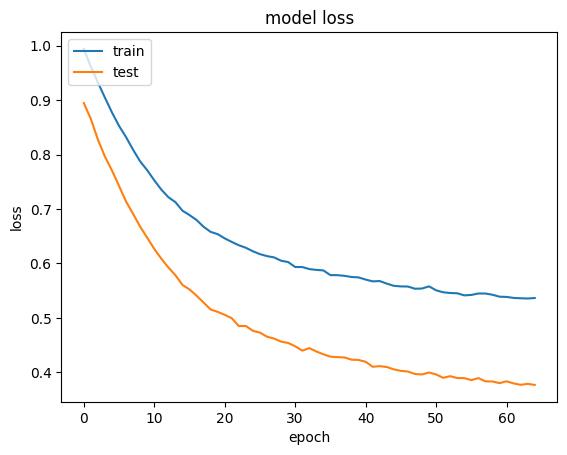

In [103]:
plt.plot(history.history["loss"][5:])
plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
refined_dataset.head()
